<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/3_Mixer_Diff_Trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: mixer, differential stage, Schmitt's trigger
### October 7th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 07/10/2021

1. OPA Mixer
2. OPA Differential Stage
3. OPA Schmitt's trigger


OPA: LM471CV (https://www.ti.com/lit/ds/symlink/lm741.pdf)


## Configuration

### Clone the GIT

In [25]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

rm: cannot remove './sample_data': No such file or directory
GitHub uservaleriopagliarino
GitHub emailvalerio.pagliarino@edu.unito.it
GitHub password··········
fatal: destination path 'Electronics-2021-UNITO' already exists and is not an empty directory.


### Install environment

In [ ]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

Start config for JupyROOT Env. on Google Coolab - It takes about 3 minutes
WGET...
Done.
UNZIP...
TAR...
APT...
Installation completed.
Shared objects loaded.
Welcome to JupyROOT 6.14/04
Completed!


### Importa moduli [no COLAB]

In [2]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

DATADIR = "../data-source"
OUTPUTDIR = "./output"

Welcome to JupyROOT 6.24/06


### Importa moduli [COLAB]

In [ ]:
%cd /content/
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle#Pickle with dict of Numpy arrays

# Variables for directories
DATADIR = "/content/Electronics-2021-UNITO/data-source"
OUTPUTDIR = "/content/Electronics-2021-UNITO/analysis/output"

/content


### Funzioni per l'importazione file Tektronix

In [3]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## OPA Mixer

In [4]:
# Somma di sinusoidi identiche
s1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_equal_sine/F0000CH1.CSV')
s1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_equal_sine/F0000CH2.CSV')
s1_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_equal_sine/F0000CH3.CSV')
time_s1ch1_f = s1_ch1_f['Data'].to_numpy().transpose()[0]
sign_s1ch1_f = s1_ch1_f['Data'].to_numpy().transpose()[1]
time_s1ch2_f = s1_ch2_f['Data'].to_numpy().transpose()[0]
sign_s1ch2_f = s1_ch2_f['Data'].to_numpy().transpose()[1]
time_s1ch3_f = s1_ch3_f['Data'].to_numpy().transpose()[0]
sign_s1ch3_f = s1_ch3_f['Data'].to_numpy().transpose()[1]

# Somma di sinusoide e sua inversa
s2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_inv_sine/F0002CH1.CSV')
s2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_inv_sine/F0002CH2.CSV')
s2_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_inv_sine/F0002CH3.CSV')
time_s2ch1_f = s2_ch1_f['Data'].to_numpy().transpose()[0]
sign_s2ch1_f = s2_ch1_f['Data'].to_numpy().transpose()[1]
time_s2ch2_f = s2_ch2_f['Data'].to_numpy().transpose()[0]
sign_s2ch2_f = s2_ch2_f['Data'].to_numpy().transpose()[1]
time_s2ch3_f = s2_ch3_f['Data'].to_numpy().transpose()[0]
sign_s2ch3_f = s2_ch3_f['Data'].to_numpy().transpose()[1]

# Somma di sinusoidi di ampiezza diversa per check guadagno somma
s3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_meas/F0005CH1.CSV')
s3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_meas/F0005CH2.CSV')
s3_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_meas/F0005CH3.CSV')
time_s3ch1_f = s3_ch1_f['Data'].to_numpy().transpose()[0]
sign_s3ch1_f = s3_ch1_f['Data'].to_numpy().transpose()[1]
time_s3ch2_f = s3_ch2_f['Data'].to_numpy().transpose()[0]
sign_s3ch2_f = s3_ch2_f['Data'].to_numpy().transpose()[1]
time_s3ch3_f = s3_ch3_f['Data'].to_numpy().transpose()[0]
sign_s3ch3_f = s3_ch3_f['Data'].to_numpy().transpose()[1]

# Somma di sinusoidi di frequenza diversa con battimenti
s4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_modulation/F0004CH1.CSV')
s4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_modulation/F0004CH2.CSV')
s4_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_modulation/F0004CH3.CSV')
time_s4ch1_f = s4_ch1_f['Data'].to_numpy().transpose()[0]
sign_s4ch1_f = s4_ch1_f['Data'].to_numpy().transpose()[1]
time_s4ch2_f = s4_ch2_f['Data'].to_numpy().transpose()[0]
sign_s4ch2_f = s4_ch2_f['Data'].to_numpy().transpose()[1]
time_s4ch3_f = s4_ch3_f['Data'].to_numpy().transpose()[0]
sign_s4ch3_f = s4_ch3_f['Data'].to_numpy().transpose()[1]

# Somma di sinusoide + onda quadra
s5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_square/F0001CH1.CSV')
s5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_square/F0001CH2.CSV')
s5_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_square/F0001CH3.CSV')
time_s5ch1_f = s5_ch1_f['Data'].to_numpy().transpose()[0]
sign_s5ch1_f = s5_ch1_f['Data'].to_numpy().transpose()[1]
time_s5ch2_f = s5_ch2_f['Data'].to_numpy().transpose()[0]
sign_s5ch2_f = s5_ch2_f['Data'].to_numpy().transpose()[1]
time_s5ch3_f = s5_ch3_f['Data'].to_numpy().transpose()[0]
sign_s5ch3_f = s5_ch3_f['Data'].to_numpy().transpose()[1]

# Somma di onda quadra + rampa
s6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_square_ramp/F0003CH1.CSV')
s6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_square_ramp/F0003CH2.CSV')
s6_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_square_ramp/F0003CH3.CSV')
time_s6ch1_f = s6_ch1_f['Data'].to_numpy().transpose()[0]
sign_s6ch1_f = s6_ch1_f['Data'].to_numpy().transpose()[1]
time_s6ch2_f = s6_ch2_f['Data'].to_numpy().transpose()[0]
sign_s6ch2_f = s6_ch2_f['Data'].to_numpy().transpose()[1]
time_s6ch3_f = s6_ch3_f['Data'].to_numpy().transpose()[0]
sign_s6ch3_f = s6_ch3_f['Data'].to_numpy().transpose()[1]

Somma di sinusoidi identiche

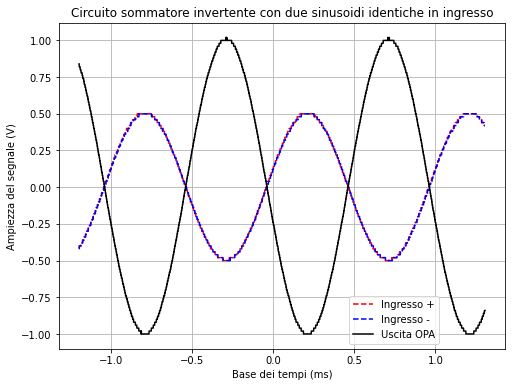

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_s1ch1_f*1000, sign_s1ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax.plot(time_s1ch2_f*1000, sign_s1ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax.plot(time_s1ch3_f*1000, sign_s1ch3_f, color = "black", label = "Uscita OPA")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Circuito sommatore invertente con due sinusoidi identiche in ingresso')

ax.grid()
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

Somma di sinusoide e sua inversa

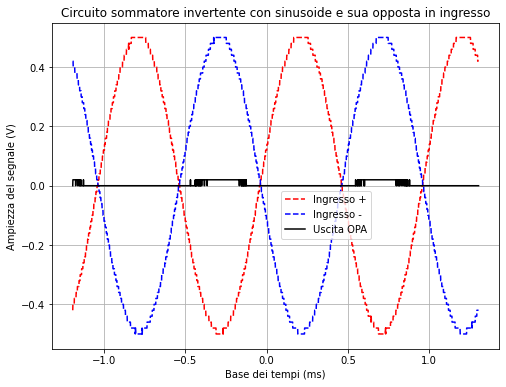

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_s2ch1_f*1000, sign_s2ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax.plot(time_s2ch2_f*1000, sign_s2ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax.plot(time_s2ch3_f*1000, sign_s2ch3_f, color = "black", label = "Uscita OPA")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Circuito sommatore invertente con sinusoide e sua opposta in ingresso')

ax.grid()
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

Somma di sinusoidi di ampiezza diversa per check guadagno somma

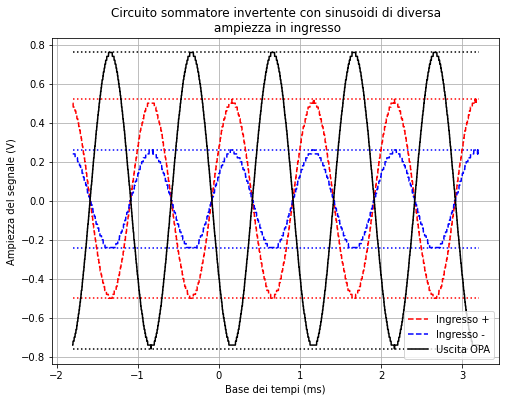

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_s3ch1_f*1000, sign_s3ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax.plot(time_s3ch2_f*1000, sign_s3ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax.plot(time_s3ch3_f*1000, sign_s3ch3_f, color = "black", label = "Uscita OPA")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Circuito sommatore invertente con sinusoidi di diversa\n ampiezza in ingresso')

ax.grid()
ax.hlines(max(sign_s3ch1_f), -1.8, 3.2, linestyle = ":", color = "red")
ax.hlines(max(sign_s3ch2_f), -1.8, 3.2, linestyle = ":", color = "blue")
ax.hlines(max(sign_s3ch3_f), -1.8, 3.2, linestyle = ":", color = "black")

ax.hlines(min(sign_s3ch1_f), -1.8, 3.2, linestyle = ":", color = "red")
ax.hlines(min(sign_s3ch2_f), -1.8, 3.2, linestyle = ":", color = "blue")
ax.hlines(min(sign_s3ch3_f), -1.8, 3.2, linestyle = ":", color = "black")


ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

Somma di sinusoidi di frequenza diversa con battimenti

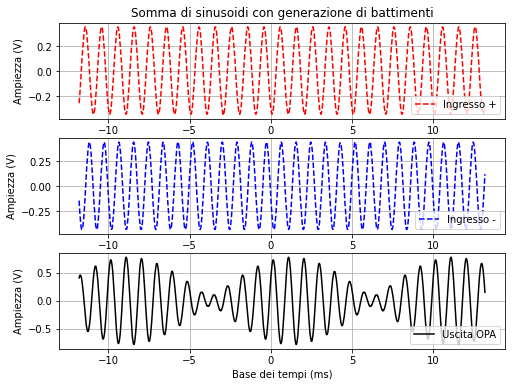

In [8]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8, 6))
ax[0].plot(time_s4ch1_f*1000, sign_s4ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax[1].plot(time_s4ch2_f*1000, sign_s4ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax[2].plot(time_s4ch3_f*1000, sign_s4ch3_f, color = "black", label = "Uscita OPA")

ax[2].set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)')
ax[0].set(ylabel='Ampiezza del segnale (V)',
       title='Somma di sinusoidi con generazione di battimenti')

#ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
#      title='Circuito sommatore invertente con somma di sinusoidi\nche evidenzia la presenza di battimenti')

for i in range(3):
  ax[i].grid()
  ax[i].legend(loc = "lower right")
  ax[i].set(ylabel='Ampiezza (V)')

plt.savefig("OPA_mixer_beats.pdf")

Somma di onda quadra + rampa

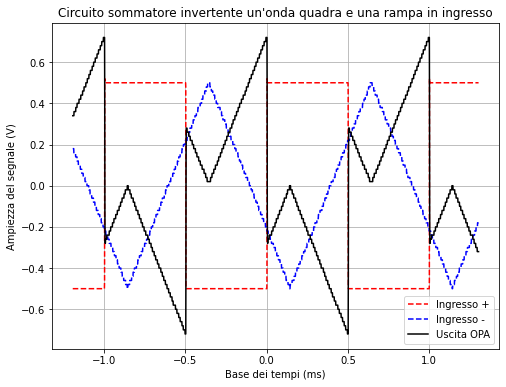

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_s6ch1_f*1000, sign_s6ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax.plot(time_s6ch2_f*1000, sign_s6ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax.plot(time_s6ch3_f*1000, sign_s6ch3_f, color = "black", label = "Uscita OPA")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title="Circuito sommatore invertente un'onda quadra e una rampa in ingresso")

ax.grid()

ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

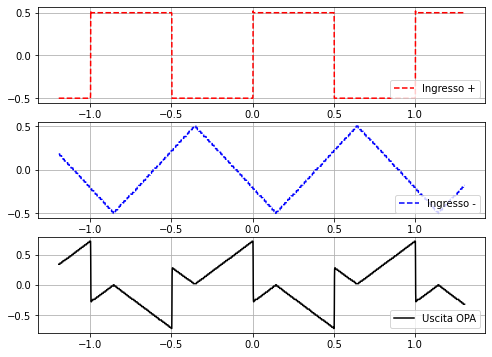

In [10]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8, 6))
ax[0].plot(time_s6ch1_f*1000, sign_s6ch1_f, color = "red", label = "Ingresso +", linestyle = "--")
ax[1].plot(time_s6ch2_f*1000, sign_s6ch2_f, color = "blue", label = "Ingresso -", linestyle = "--")
ax[2].plot(time_s6ch3_f*1000, sign_s6ch3_f, color = "black", label = "Uscita OPA")



#ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
#      title='Circuito sommatore invertente con somma di sinusoidi\nche evidenzia la presenza di battimenti')

for i in range(3):
  ax[i].grid()
  ax[i].legend(loc = "lower right")



## OPA Difference amplifier

In [11]:
# Differenza tra sinusoidi identiche
d1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine/F0007CH1.CSV')
d1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine/F0007CH2.CSV')
time_d1ch1_f = d1_ch1_f['Data'].to_numpy().transpose()[0]
sign_d1ch1_f = d1_ch1_f['Data'].to_numpy().transpose()[1]
time_d1ch2_f = d1_ch2_f['Data'].to_numpy().transpose()[0]
sign_d1ch2_f = d1_ch2_f['Data'].to_numpy().transpose()[1]

# Differenza tra sinusoidi identiche, zoom
d2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine_detail/F0006CH1.CSV')
d2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine_detail/F0006CH2.CSV')
time_d2ch1_f = d2_ch1_f['Data'].to_numpy().transpose()[0]
sign_d2ch1_f = d2_ch1_f['Data'].to_numpy().transpose()[1]
time_d2ch2_f = d2_ch2_f['Data'].to_numpy().transpose()[0]
sign_d2ch2_f = d2_ch2_f['Data'].to_numpy().transpose()[1]

# Differenza tra sinusoide a media nulla e sinusoide con offset
d3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_sine_square/F0008CH1.CSV')
d3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_sine_square/F0008CH2.CSV')
time_d3ch1_f = d3_ch1_f['Data'].to_numpy().transpose()[0]
sign_d3ch1_f = d3_ch1_f['Data'].to_numpy().transpose()[1]
time_d3ch2_f = d3_ch2_f['Data'].to_numpy().transpose()[0]
sign_d3ch2_f = d3_ch2_f['Data'].to_numpy().transpose()[1]

# Differenza tra sinusoide e onda quadra
d4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_get_offset/F0011CH1.CSV')
d4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_get_offset/F0011CH2.CSV')
time_d4ch1_f = d4_ch1_f['Data'].to_numpy().transpose()[0]
sign_d4ch1_f = d4_ch1_f['Data'].to_numpy().transpose()[1]
time_d4ch2_f = d4_ch2_f['Data'].to_numpy().transpose()[0]
sign_d4ch2_f = d4_ch2_f['Data'].to_numpy().transpose()[1]

# Differenza tra onda quadra per verifica del guadagno della differenza
d5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_meas/F0010CH1.CSV')
d5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_meas/F0010CH2.CSV')
time_d5ch1_f = d5_ch1_f['Data'].to_numpy().transpose()[0]
sign_d5ch1_f = d5_ch1_f['Data'].to_numpy().transpose()[1]
time_d5ch2_f = d5_ch2_f['Data'].to_numpy().transpose()[0]
sign_d5ch2_f = d5_ch2_f['Data'].to_numpy().transpose()[1]

# Differenza tra onda quadra e rampa
d6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_ramp/F0009CH1.CSV')
d6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_ramp/F0009CH2.CSV')
time_d6ch1_f = d6_ch1_f['Data'].to_numpy().transpose()[0]
sign_d6ch1_f = d6_ch1_f['Data'].to_numpy().transpose()[1]
time_d6ch2_f = d6_ch2_f['Data'].to_numpy().transpose()[0]
sign_d6ch2_f = d6_ch2_f['Data'].to_numpy().transpose()[1]

## OPA Schmitt's trigger

In [14]:
R1= 9810
R2= 9950
R3= 9890


R1_err = 1/100*R1 + 4*1
R2_err = 1/100*R2 + 4*1
R3_err = 1/100*R3 + 4*1

print(R1,'+-',R1_err)
print(R2,'+-',R2_err)
print(R3,'+-',R3_err)




9810 +- 102.10000000000001
9950 +- 103.5
9890 +- 102.9


In [15]:
# Trigger di Schmitt su segnale sinusoidale pulito
t1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH1.CSV')
t1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH2.CSV')
t1_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH3.CSV')
time_t1ch1_f = t1_ch1_f['Data'].to_numpy().transpose()[0]
sign_t1ch1_f = t1_ch1_f['Data'].to_numpy().transpose()[1]
time_t1ch2_f = t1_ch2_f['Data'].to_numpy().transpose()[0]
sign_t1ch2_f = t1_ch2_f['Data'].to_numpy().transpose()[1]
time_t1ch2_f = t1_ch3_f['Data'].to_numpy().transpose()[0]
sign_t1ch2_f = t1_ch3_f['Data'].to_numpy().transpose()[1]

# Trigger di Schmitt per valutazione velocità di commutazione
t2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH1.CSV')
t2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH2.CSV')
t2_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH3.CSV')
time_t2ch1_f = t2_ch1_f['Data'].to_numpy().transpose()[0]
sign_t2ch1_f = t2_ch1_f['Data'].to_numpy().transpose()[1]
time_t2ch2_f = t2_ch2_f['Data'].to_numpy().transpose()[0]
sign_t2ch2_f = t2_ch2_f['Data'].to_numpy().transpose()[1]
time_t2ch2_f = t2_ch3_f['Data'].to_numpy().transpose()[0]
sign_t2ch2_f = t2_ch3_f['Data'].to_numpy().transpose()[1]

# Segnale di ingresso
t3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_input/F0012CH1.CSV')
t3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_input/F0012CH2.CSV')
time_t3ch1_f = t3_ch1_f['Data'].to_numpy().transpose()[0]
sign_t3ch1_f = t3_ch1_f['Data'].to_numpy().transpose()[1]
time_t3ch2_f = t3_ch2_f['Data'].to_numpy().transpose()[0]
sign_t3ch2_f = t3_ch2_f['Data'].to_numpy().transpose()[1]

# Trigger di Schmitt, funzionamento con segnale dotato di rumore
t4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH1.CSV')
t4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH2.CSV')
t4_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH3.CSV')
time_t4ch1_f = t4_ch1_f['Data'].to_numpy().transpose()[0]
sign_t4ch1_f = t4_ch1_f['Data'].to_numpy().transpose()[1]
time_t4ch2_f = t4_ch2_f['Data'].to_numpy().transpose()[0]
sign_t4ch2_f = t4_ch2_f['Data'].to_numpy().transpose()[1]
time_t4ch2_f = t4_ch3_f['Data'].to_numpy().transpose()[0]
sign_t4ch2_f = t4_ch3_f['Data'].to_numpy().transpose()[1]

# Trigger di Schmitt, funzionamento con segnale pulto
t5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH1.CSV')
t5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH2.CSV')
t5_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH3.CSV')
time_t5ch1_f = t5_ch1_f['Data'].to_numpy().transpose()[0]
sign_t5ch1_f = t5_ch1_f['Data'].to_numpy().transpose()[1]
time_t5ch2_f = t5_ch2_f['Data'].to_numpy().transpose()[0]
sign_t5ch2_f = t5_ch2_f['Data'].to_numpy().transpose()[1]
time_t5ch2_f = t5_ch3_f['Data'].to_numpy().transpose()[0]
sign_t5ch2_f = t5_ch3_f['Data'].to_numpy().transpose()[1]

# Baseline trigger ad anello aperto, funzionamento con segnale dotato di rumore
t6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH1.CSV')
t6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH2.CSV')
t6_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH3.CSV')
time_t6ch1_f = t6_ch1_f['Data'].to_numpy().transpose()[0]
sign_t6ch1_f = t6_ch1_f['Data'].to_numpy().transpose()[1]
time_t6ch2_f = t6_ch2_f['Data'].to_numpy().transpose()[0]
sign_t6ch2_f = t6_ch2_f['Data'].to_numpy().transpose()[1]
time_t6ch2_f = t6_ch3_f['Data'].to_numpy().transpose()[0]
sign_t6ch2_f = t6_ch3_f['Data'].to_numpy().transpose()[1]

# Trigger di Schmitt, funzionamento fuori dal range di frequenza consentito
t7_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH1.CSV')
t7_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH2.CSV')
t7_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH3.CSV')
time_t7ch1_f = t7_ch1_f['Data'].to_numpy().transpose()[0]
sign_t7ch1_f = t7_ch1_f['Data'].to_numpy().transpose()[1]
time_t7ch2_f = t7_ch2_f['Data'].to_numpy().transpose()[0]
sign_t7ch2_f = t7_ch2_f['Data'].to_numpy().transpose()[1]
time_t7ch2_f = t7_ch3_f['Data'].to_numpy().transpose()[0]
sign_t7ch2_f = t7_ch3_f['Data'].to_numpy().transpose()[1]


## Visualizzazioni XY

Verifica della linearità dell'amplificazione, anello chiuso - Ingresso Invertente

LinregressResult(slope=-1.0069435002501688, intercept=0.01005410727845981, rvalue=-0.9994460257568253, pvalue=2.7645724883702184e-136, stderr=0.0035149948277526113, intercept_stderr=0.0010576566102842688)


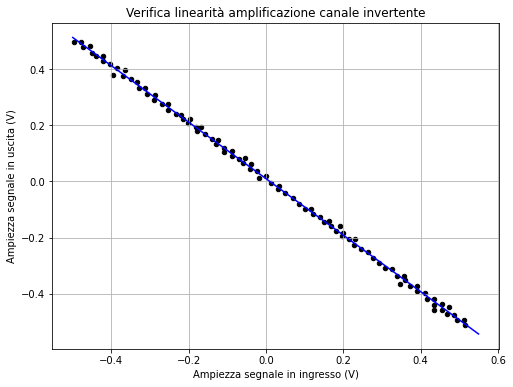

In [16]:
import scipy.stats

LIN_CHinv = pd.read_csv(f"{DATADIR}/7-10-21/XY/LIN_CH1.csv")

LIN_CHinvx = LIN_CHinv.to_numpy().transpose()[0]
LIN_CHinvy = LIN_CHinv.to_numpy().transpose()[1]
LIN_CHinvx = LIN_CHinvx[(LIN_CHinvx >= -0.6) & (LIN_CHinvx <= 15)]
LIN_CHinvy = LIN_CHinvy[(LIN_CHinvy >= -0.6) & (LIN_CHinvy <= 15)]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(LIN_CHinvx, LIN_CHinvy, s=20, color = "black")

res_inv = sp.stats.linregress(LIN_CHinvx, LIN_CHinvy)
x_fit = np.linspace(-0.5, 0.55, 200)
y_fit = x_fit * res_inv[0] + res_inv[1]

ax.plot(x_fit, y_fit, color = "blue")
ax.grid()

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Verifica linearità amplificazione canale invertente')

print(res_inv)

Verifica della linearità dell'amplificazione, anello chiuso - Ingresso NON Invertente

LinregressResult(slope=0.9969926087384732, intercept=-0.009760942014346284, rvalue=0.9995830880259264, pvalue=4.1687455003747657e-131, stderr=0.0031421383817731344, intercept_stderr=0.0009582711478835115)


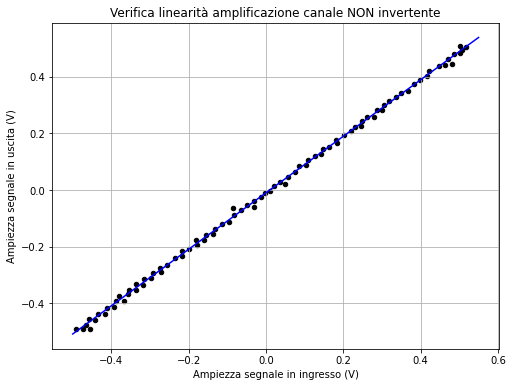

In [17]:
import scipy.stats

LIN_CH = pd.read_csv(f"{DATADIR}/7-10-21/XY/LIN_CH2.csv")

LIN_CHx = LIN_CH.to_numpy().transpose()[0]
LIN_CHy = LIN_CH.to_numpy().transpose()[1] * -1.
LIN_CHx = LIN_CHx[(LIN_CHx >= -0.6) & (LIN_CHx <= 0.6)]
LIN_CHy = LIN_CHy[(LIN_CHy >= -0.6) & (LIN_CHy <= 0.6)]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(LIN_CHx, LIN_CHy, s=20, color = "black")

res_ni = sp.stats.linregress(LIN_CHx, LIN_CHy)
x_fit = np.linspace(-0.5, 0.55, 200)
y_fit = x_fit * res_ni[0] + res_ni[1]

ax.plot(x_fit, y_fit, color = "blue")
ax.grid()

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Verifica linearità amplificazione canale NON invertente')

print(res_ni)

CH1 vs CH2

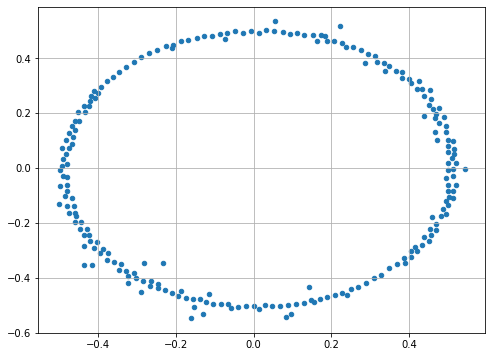

In [18]:
CH1vsCH2 = pd.read_csv(f"{DATADIR}/7-10-21/XY/CH1vsCH2.csv")

CH1vsCH2x = CH1vsCH2.to_numpy().transpose()[0]
CH1vsCH2y = CH1vsCH2.to_numpy().transpose()[1]
CH1vsCH2x = CH1vsCH2x[(CH1vsCH2x >= -0.6) & (CH1vsCH2x <= 15)]
CH1vsCH2y = CH1vsCH2y[(CH1vsCH2y >= -0.6) & (CH1vsCH2y <= 15)]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(CH1vsCH2x, CH1vsCH2y, s=20)

ax.grid()

CH1 vs OUT

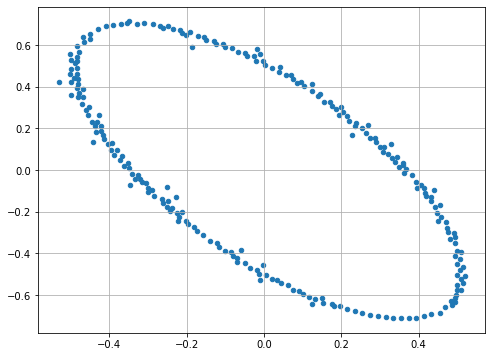

In [19]:
CH1vsOUT = pd.read_csv(f"{DATADIR}/7-10-21/XY/CH1vsOUT.csv")

CH1vsOUTx = CH1vsOUT.to_numpy().transpose()[0]
CH1vsOUTy = CH1vsOUT.to_numpy().transpose()[1]
CH1vsOUTx = CH1vsOUTx[(CH1vsOUTx >= -0.6) & (CH1vsOUTx <= 15)]
CH1vsOUTy = CH1vsOUTy[(CH1vsOUTy >= -0.8) & (CH1vsOUTy <= 15)]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(CH1vsOUTx, CH1vsOUTy, s=20)

ax.grid()

CH2 vs OUT

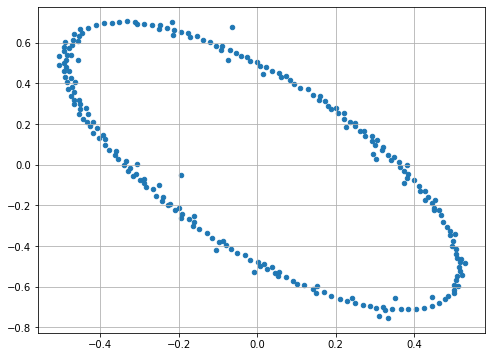

In [20]:
CH2vsOUT = pd.read_csv(f"{DATADIR}/7-10-21/XY/CH2vsOUT.csv")

CH2vsOUTx = CH2vsOUT.to_numpy().transpose()[0]
CH2vsOUTy = CH2vsOUT.to_numpy().transpose()[1]
CH2vsOUTx = CH2vsOUTx[(CH2vsOUTx >= -0.6) & (CH2vsOUTx <= 15)]
CH2vsOUTy = CH2vsOUTy[(CH2vsOUTy >= -0.8) & (CH2vsOUTy <= 15)]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(CH2vsOUTx, CH2vsOUTy, s=20)

ax.grid()

Ciclo di Isteresi del trigger di Schmitt a 100 Hz

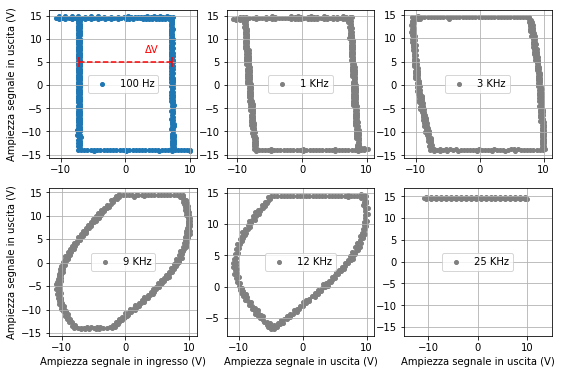

In [28]:
trig_ist_100H = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_100Hz.csv")
trig_ist_12K  = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_12KHz.csv")
trig_ist_1K   = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_1KHz.csv")
trig_ist_25K  = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_25KHz.csv")
trig_ist_9K  = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_9KHz.csv")
trig_ist_3K  = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_3KHz.csv")

trig_ist_100Hx = trig_ist_100H.to_numpy().transpose()[0]
trig_ist_100Hy = trig_ist_100H.to_numpy().transpose()[1]
trig_ist_100Hx = trig_ist_100Hx[(trig_ist_100Hx >= -15) & (trig_ist_100Hx <= 15)]
trig_ist_100Hy = trig_ist_100Hy[(trig_ist_100Hy >= -15) & (trig_ist_100Hy <= 15)]

trig_ist_12Kx = trig_ist_12K.to_numpy().transpose()[0]
trig_ist_12Ky = trig_ist_12K.to_numpy().transpose()[1]
trig_ist_12Kx = trig_ist_12Kx[(trig_ist_12Kx >= -15) & (trig_ist_12Kx <= 15)]
trig_ist_12Ky = trig_ist_12Ky[(trig_ist_12Ky >= -15) & (trig_ist_12Ky <= 15)]

trig_ist_1Kx = trig_ist_1K.to_numpy().transpose()[0]
trig_ist_1Ky = trig_ist_1K.to_numpy().transpose()[1]
trig_ist_1Kx = trig_ist_1Kx[(trig_ist_1Kx >= -15) & (trig_ist_1Kx <= 15)]
trig_ist_1Ky = trig_ist_1Ky[(trig_ist_1Ky >= -15) & (trig_ist_1Ky <= 15)]

trig_ist_25Kx = trig_ist_25K.to_numpy().transpose()[0]
trig_ist_25Ky = trig_ist_25K.to_numpy().transpose()[1]
trig_ist_25Kx = trig_ist_25Kx[(trig_ist_25Kx >= -15) & (trig_ist_25Kx <= 15)]
trig_ist_25Ky = trig_ist_25Ky[(trig_ist_25Ky >= -15) & (trig_ist_25Ky <= 15)]

trig_ist_3Kx = trig_ist_3K.to_numpy().transpose()[0]
trig_ist_3Ky = trig_ist_3K.to_numpy().transpose()[1]
trig_ist_3Kx = trig_ist_3Kx[(trig_ist_3Kx >= -15) & (trig_ist_3Kx <= 15)]
trig_ist_3Ky = trig_ist_3Ky[(trig_ist_3Ky >= -15) & (trig_ist_3Ky <= 15)]

trig_ist_9Kx = trig_ist_9K.to_numpy().transpose()[0]
trig_ist_9Ky = trig_ist_9K.to_numpy().transpose()[1]
trig_ist_9Kx = trig_ist_9Kx[(trig_ist_9Kx >= -15) & (trig_ist_9Kx <= 15)]
trig_ist_9Ky = trig_ist_9Ky[(trig_ist_9Ky >= -15) & (trig_ist_9Ky <= 15)]

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(9, 6))

ccol = "gray"
a = 37
a2 = 93
b = 279
b2 = 225
c= 1
p0=(trig_ist_100Hx[a]+trig_ist_100Hx[a2])/2 + 10**(-8)
p1 = (trig_ist_100Hx[b]+trig_ist_100Hx[b2])/2 + 10**(-8)
#ax.plot(trig_ist_100Hx[b2],trig_ist_100Hy[b2],'ro')
ax[0][0].hlines(5, p0,p1, color='r',linestyle = "--")
ax[0][0].vlines(p0,5-c,5+c,color='r')
ax[0][0].vlines(p1,5-c,5+c,color='r')
ax[0][0].text(3,7,'\u0394'+'V',color='r')

ax[0][0].scatter(trig_ist_100Hx, trig_ist_100Hy, s=16, label="100 Hz")
ax[0][0].grid()
ax[0][0].set(ylabel='Ampiezza segnale in uscita (V)')

ax[0][0].legend(loc = "center")

ax[0][1].scatter(trig_ist_1Kx, trig_ist_1Ky, s=16, label="1 KHz", color = ccol)
ax[0][1].grid()
ax[0][1].legend(loc = "center")

ax[0][2].scatter(trig_ist_3Kx, trig_ist_3Ky, s=16, label="3 KHz", color = ccol)
ax[0][2].grid()
ax[0][2].legend(loc = "center")

ax[1][0].scatter(trig_ist_9Kx, trig_ist_9Ky, s=16, label="9 KHz", color = ccol)
ax[1][0].grid()
ax[1][0].set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)')
ax[1][0].legend(loc = "center")

ax[1][1].scatter(trig_ist_12Kx, trig_ist_12Ky, s=16, label="12 KHz", color = ccol)
ax[1][1].grid()
ax[1][1].set(xlabel='Ampiezza segnale in uscita (V)')
ax[1][1].legend(loc = "center")

ax[1][2].scatter(trig_ist_25Kx, trig_ist_25Ky, s=16, label="25 KHz", color = ccol)
ax[1][2].set(xlim=(-15, 15), ylim=(-17, 17))
ax[1][2].grid()
ax[1][2].set(xlabel='Ampiezza segnale in uscita (V)')
ax[1][2].legend(loc = "center")

plt.savefig(f"{OUTPUTDIR}/OPA-trigger-histeresis-table.pdf")

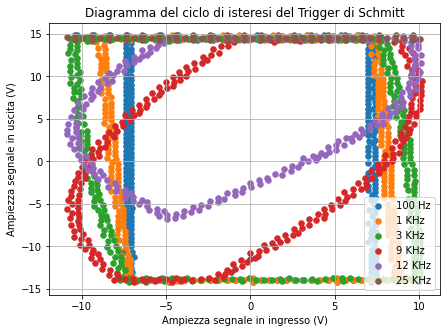

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 5))
ax.scatter(trig_ist_100Hx, trig_ist_100Hy, s=30, label="100 Hz")
ax.scatter(trig_ist_1Kx, trig_ist_1Ky, s=30, label="1 KHz")
ax.scatter(trig_ist_3Kx, trig_ist_3Ky, s=30, label="3 KHz")
ax.scatter(trig_ist_9Kx, trig_ist_9Ky, s=30, label="9 KHz")
ax.scatter(trig_ist_12Kx, trig_ist_12Ky, s=30, label="12 KHz")
ax.scatter(trig_ist_25Kx, trig_ist_25Ky, s=30, label="25 KHz")
ax.legend(loc = "lower right")
ax.grid()

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Diagramma del ciclo di isteresi del Trigger di Schmitt')
plt.savefig(f"{OUTPUTDIR}/OPA-trigger-histeresis-overlapped.pdf")

(array([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  65,  66,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 121, 122, 125, 127, 130, 132, 133, 136, 138,
       141, 143, 146, 148, 151, 153, 156, 157, 160, 162, 165, 168, 171,
       174, 177, 180, 183, 186, 188, 190, 193, 196, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 249, 250, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306]),)
isteresi =  14.423906500802566 +- 0.03607087435521005  V


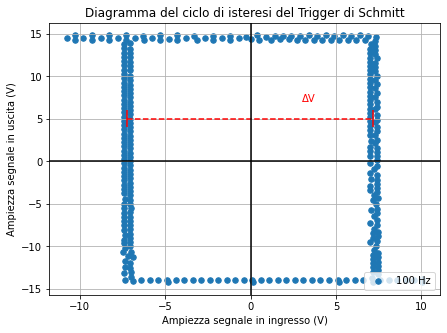

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 5))
ax.scatter(trig_ist_100Hx, trig_ist_100Hy, s=30, label="100 Hz")

ax.legend(loc = "lower right")
ax.grid()
ax.axhline(0, color='black')
ax.axvline(0, color='black')

ax.plot()
ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Diagramma del ciclo di isteresi del Trigger di Schmitt')
plt.savefig(f"{OUTPUTDIR}/OPA-trigger-histeresis.pdf")



print(np.where(trig_ist_100Hy <1  ))
trig_ist_100Hy[93] #37 #279
a = 37
a2 = 93
b = 279
b2 = 225
c= 1
p0=(trig_ist_100Hx[a]+trig_ist_100Hx[a2])/2 + 10**(-8)
p1 = (trig_ist_100Hx[b]+trig_ist_100Hx[b2])/2 + 10**(-8)
#ax.plot(trig_ist_100Hx[b2],trig_ist_100Hy[b2],'ro')
ax.hlines(5, p0,p1, color='r',linestyle = "--")
ax.vlines(p0,5-c,5+c,color='r')
ax.vlines(p1,5-c,5+c,color='r')
Is = p1-p0

err_Hx = 0.5/100*trig_ist_100Hx + 10**-7
err_Hy = 0.5/100*trig_ist_100Hy + 10**-7
p0_err = 1/2*np.sqrt((err_Hx[a])**2+(err_Hx[a2])**2)
p1_err = 1/2*np.sqrt((err_Hx[b])**2+(err_Hx[b2])**2)
Is_err = np.sqrt((p0_err)**2+(p1_err)**2)

print('isteresi = ',Is,'+-',Is_err,' V')
ax.text(3,7,'\u0394'+'V',color='r')

plt.savefig(f"{OUTPUTDIR}/OPA-trigger-histeresis.pdf")


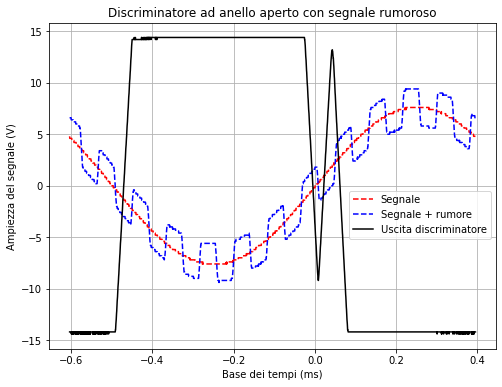

In [24]:
open_comp1_ = openTek(f"{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH1.CSV")
open_comp2_ = openTek(f"{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH2.CSV")
open_comp3_ = openTek(f"{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH3.CSV")



open_comp1_time = open_comp1_['Data'].to_numpy().transpose()[0] 
open_comp2_time = open_comp2_['Data'].to_numpy().transpose()[0] 
open_comp3_time = open_comp3_['Data'].to_numpy().transpose()[0] 

open_comp1_sign = open_comp1_['Data'].to_numpy().transpose()[1]
open_comp2_sign = open_comp2_['Data'].to_numpy().transpose()[1]
open_comp3_sign = open_comp3_['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(open_comp1_time*1000, open_comp1_sign, color = "red", label = "Segnale", linestyle = "--")
ax.plot(open_comp2_time*1000, open_comp2_sign, color = "blue", label = "Segnale + rumore", linestyle = "--")
ax.plot(open_comp3_time*1000, open_comp3_sign, color = "black", label = "Uscita discriminatore")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Discriminatore ad anello aperto con segnale rumoroso')

ax.grid()
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.savefig(f"{OUTPUTDIR}/noisy-open-ring.pdf")

## Commit changes

In [31]:
%cd /content/Electronics-2021-UNITO/
!git pull
!git add .
!git commit -m "Plots from data analysis"
!git push 

/content/Electronics-2021-UNITO
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
From https://github.com/valeriopagliarino/Electronics-2021-UNITO
   d29b9e5..0a9acaa  main       -> origin/main
Updating d29b9e5..0a9acaa
Fast-forward
 analysis/3_Mixer_Diff_Trigger.ipynb | 106 +++++++++++++++++++-----------------
 analysis/output/OPA_mixer_beats.pdf | Bin 25379 -> 28954 bytes
 lab-reports/analog.tex              |   4 +-
 3 files changed, 58 insertions(+), 52 deletions(-)
[main c2eb0c6] Plots from data analysis
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 analysis/output/noisy-open-ring.pdf
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 18.43 KiB | 18.43 MiB/s, done.
Total 5 (delta 3), reused 0